In [25]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

#加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'EOSUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

#读取数据
Time_dict = ds.bar_reader(path,props) 

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


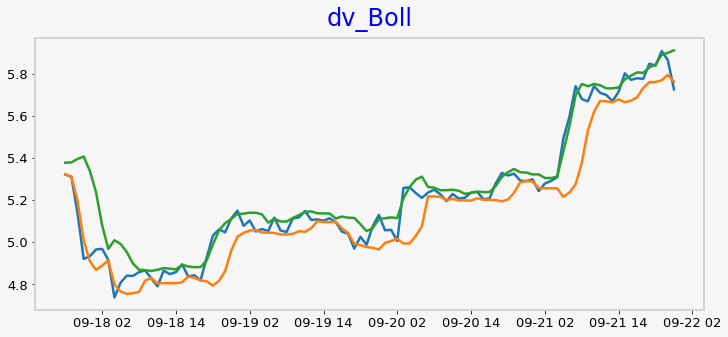

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_Boll(dv,BollDown,BollUp,chart_name='dv_Boll',n=0):
    fig,(ax) = plt.subplots(1,1,sharex=True, figsize=(12,5))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax.plot(BollDown.iloc[n:],alpha=1)
    ax.plot(BollUp.iloc[n:],alpha=1)
    plt.show()

MA_j = dv1H.add_formula('MA_j', "Ts_Mean(close,5)", add_data=True)
MD_j = dv1H.add_formula('MD_j', 'StdDev(close,5)',  add_data=True)
BollDown_j = dv1H.add_formula('BollDown_j', 'MA_j-1.1*MD_j',  add_data=True)
BollUp_j = dv1H.add_formula('BollUp_j', 'MA_j+1.1*MD_j',  add_data=True)

BollDown = dv1H.get_ts('BollDown_j', date_type='datetime')
BollUp = dv1H.get_ts('BollUp_j', date_type='datetime')

plot_Boll(dv1H, BollDown.iloc[:,0], BollUp.iloc[:,0], n=-100)

In [219]:
#进场信号
longBoll = dv1H.add_formula('longBoll','If((close>Delay(close,1))&&(close>BollDown_j)&& (Delay(close,1)<Delay(BollDown_j,1)),2,0)',add_data=True)
shorBoll =dv1H.add_formula('shortBoll','If((close<Delay(close,1))&&(close<BollUp_j) && (Delay(close,1)>Delay(BollDown_j,1)),-2,0)',add_data=True)

#出场信号
closelongBoll = dv1H.add_formula("closelongBoll","If(shortBoll==-2,1,0)", add_data=True)
closeshortBoll = dv1H.add_formula("closeshortBoll","If(longBoll==2,-1,0)", add_data=True)

dv1H.get_ts('longBoll').stack()[dv1H.get_ts('longBoll').stack()==2].head()#观察出现做多信号的时间点

Field [longBoll] is overwritten.
Field [shortBoll] is overwritten.
Field [closelongBoll] is overwritten.
Field [closeshortBoll] is overwritten.


trade_date      symbol         
20180601070000  EOSUSDT:binance    2.0
20180601130000  EOSUSDT:binance    2.0
20180601200000  EOSUSDT:binance    2.0
20180602040000  EOSUSDT:binance    2.0
20180603060000  EOSUSDT:binance    2.0
dtype: float64

In [220]:
from jaqs_fxdayu.research import TimingDigger

tdBoll=TimingDigger(output_folder=".", output_format='pdf',signal_name='Boll')

def TimingSignal(td, dv1H, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv1H.get_ts(long),
        exit_signal=dv1H.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv1H.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv1H.get_ts(short),
        exit_signal=dv1H.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv1H.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [224]:
TimingSignal(tdBoll, dv1H,'longBoll','shortBoll','closelongBoll','closeshortBoll', 7, 0.05, 0.8)#调取数据
tdBoll.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 11%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 43%
*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               22.803  -23.720     0.085
p-value               0.000    0.000     0.932
mean                  0.016   -0.017     0.000
std                   0.019    0.019     0.025
info_ratio            0.845   -0.891     0.002
skewness              2.553   -1.966     0.217
kurtosis              8.575    4.036     4.315
pct5                  0.001   -0.060    -0.044
pct25                 0.004   -0.020    -0.010
pct50                 0.011   -0.010     0.000
pct75                 0.020   -0.004     0.011
pct95                 0.056   -0.001     0.039
occurance           729.000  710.000  1439.000
win_ratio               NaN      NaN     0.507
win_mean/loss_mean      NaN      NaN     0.981


In [225]:
tdBoll.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               21.169  -21.465     0.561
p-value               0.000    0.000     0.575
mean                  0.018   -0.019     0.000
std                   0.021    0.020     0.027
info_ratio            0.862   -0.919     0.017
skewness              2.414   -1.755     0.186
kurtosis              7.535    2.966     3.621
pct5                  0.001   -0.061    -0.050
pct25                 0.004   -0.023    -0.010
pct50                 0.011   -0.011     0.001
pct75                 0.023   -0.005     0.013
pct95                 0.063   -0.001     0.043
occurance           604.000  547.000  1151.000
win_ratio               NaN      NaN     0.525
win_mean/loss_mean      NaN      NaN     0.952


In [226]:
tdBoll.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               10.171  -12.275   -1.677
p-value               0.000    0.000    0.095
mean                  0.010   -0.011   -0.002
std                   0.011    0.011    0.015
info_ratio            0.913   -0.964   -0.099
skewness              2.652   -2.485    0.063
kurtosis              8.929    8.391    4.812
pct5                  0.001   -0.031   -0.022
pct25                 0.003   -0.015   -0.008
pct50                 0.007   -0.007   -0.002
pct75                 0.013   -0.003    0.006
pct95                 0.033   -0.001    0.018
occurance           125.000  163.000  288.000
win_ratio               NaN      NaN    0.434
win_mean/loss_mean      NaN      NaN    0.976
